In this notebook, we are going to examine the data from my house water consumption and try to find if there is a leak. To do so, we’ll go from a qualititave analysis to a Bayesian model.

# Qualitative data analysis

I have a data file with two columns: the cubic meters of water used every day and the water index on that day. Let’s load it.

In [1]:
import pandas as pd

df = pd.read_csv("leak_data_2022_2024.csv", parse_dates=['JOUR']).set_index('JOUR')

df.head()

,M3,RELEVÉ
JOUR,,
2022-07-12,0.362,405.939
2022-07-13,0.132,406.071
2022-07-14,0.313,406.384
2022-07-15,0.467,406.851
2022-07-16,0.433,407.284


What does the data look like?

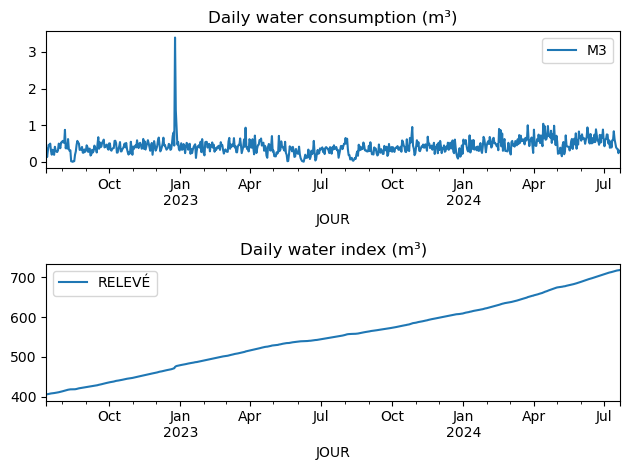

In [2]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2)
df.plot(y='M3', ax=ax1)
df.plot(y='RELEVÉ', ax=ax2)
ax1.set_title('Daily water consumption (m³)')
ax2.set_title('Daily water index (m³)')
fig.tight_layout()

It’s not easy making out a leak from a visual analysis. The daily consumption seems to be around 0.5 m³ but I don’t see a real trend in daily values. There could be a trend in the water index, but it’s also subtle.


What about an analysis by month? Do we see an effect there?

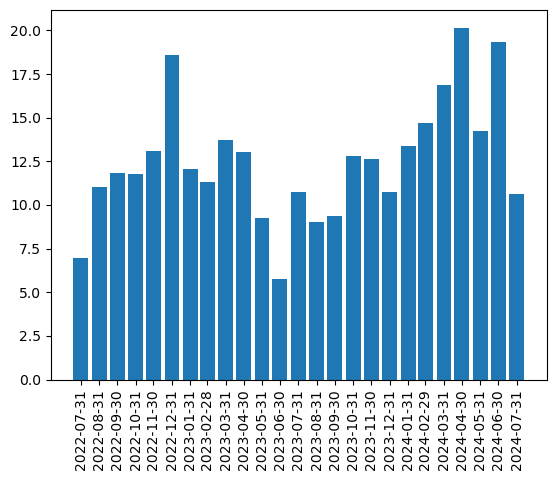

In [3]:
df_monthly = df.resample('ME').sum()

plt.bar(df_monthly.index, df_monthly['M3'], width=25)
plt.xticks(df_monthly.index, rotation=90);

Here, we do see that monthly consumption is quite higher in 2024 than at the end of 2022. Let’s try to see a month over month comparison, since we do have roughly two years of data.

<Axes: xlabel='month'>

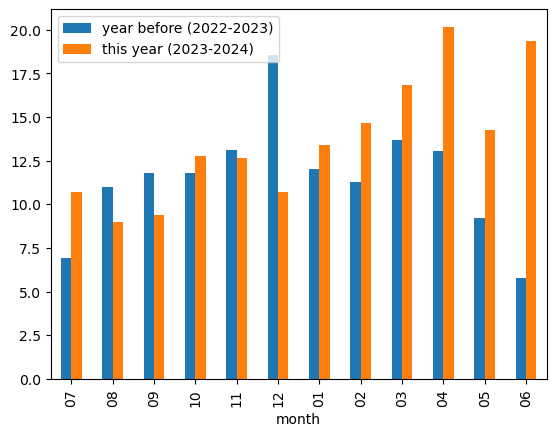

In [4]:
df_monthly['month'] = df_monthly.index.strftime('%m')

pd.DataFrame([df_monthly.set_index('month')['M3'].iloc[:12], df_monthly.set_index('month')['M3'].iloc[12:-1]], index=['year before (2022-2023)', 'this year (2023-2024)']).T.plot.bar()

In this view, it seems indeed that starting in January this year, there has been a substantial increase of monthly water consumption.

# Linear model slope analysis

To see if we can find a trend let’s use a linear model. We can split the full data into chunks that would on average, behave as lines and we can then see if the slopes change as a function of time.

We can use the `pandas` `rolling` window function to which we apply a linear regression that computes a slope. 

We will use a 30 day rolling window to mimick the montly analyis we just did.

In [5]:
from scipy.stats import linregress

def index_to_num(index):
    return index.values.astype(float) / 1e9 / 3600 / 24

def compute_slope(s):
    x_num = index_to_num(s.index) 
    y = s.values
    reg = linregress(x_num, y)
    return reg.slope

rolling_slopes = df['RELEVÉ'].rolling(30, center=True).apply(func=compute_slope)

rolling_slopes.describe()


count    712.000000
mean       0.422559
std        0.110859
min        0.168674
25%        0.348944
50%        0.414397
75%        0.460289
max        0.696360
Name: RELEVÉ, dtype: float64

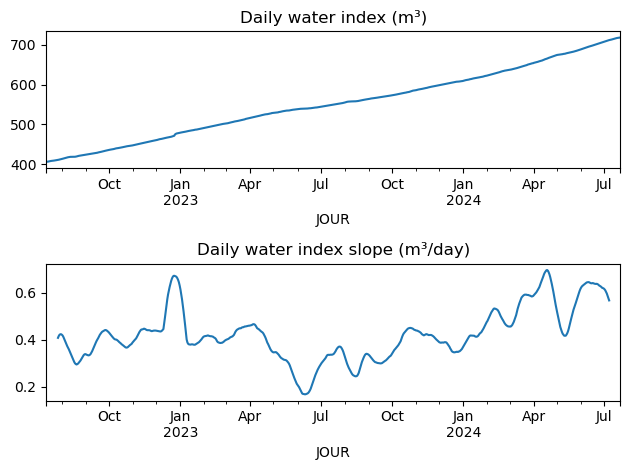

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
df['RELEVÉ'].plot(ax=ax1)
rolling_slopes.plot(ax=ax2)
ax1.set_title('Daily water index (m³)')
ax2.set_title('Daily water index slope (m³/day)')
fig.tight_layout()

As we can see in the above, the slope changes quite a bit with mean around 0.4 and ending in higher values around the end of the data, which could indicate that a leak has appeared.

We can make a better graph to highlight this by plotting only the start and the end slopes:

C:\Users\FL232714\AppData\Local\Temp\ipykernel_32\3281566500.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['RELEVÉ'][0] + (index_to_num(df.index) - index_to_num(df.index)[0]) * slope1,
C:\Users\FL232714\AppData\Local\Temp\ipykernel_32\3281566500.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['RELEVÉ'][-1] - (index_to_num(df.index)[-1] - index_to_num(df.index)) * slope2,


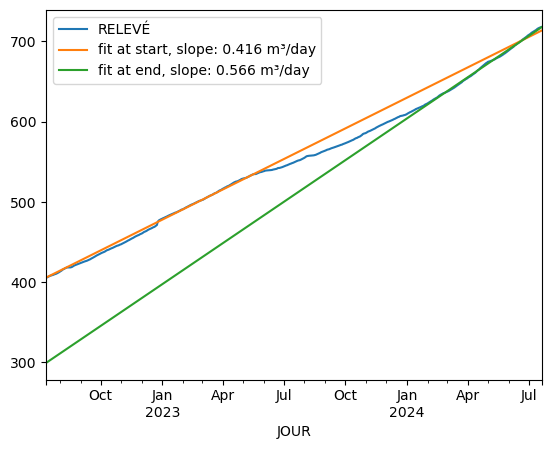

In [7]:
fig, ax = plt.subplots()

df.plot(y='RELEVÉ', ax=ax)


slope1 = compute_slope(df['RELEVÉ'].iloc[:365])
slope2 = compute_slope(df['RELEVÉ'].iloc[-180:])

ax.plot(df.index, 
        df['RELEVÉ'][0] + (index_to_num(df.index) - index_to_num(df.index)[0]) * slope1,
        label=f'fit at start, slope: {slope1:.3} m³/day')

ax.plot(df.index, 
        df['RELEVÉ'][-1] - (index_to_num(df.index)[-1] - index_to_num(df.index)) * slope2,
        label=f'fit at end, slope: {slope2:.3} m³/day')

ax.legend();


Let’s see if we can develop a quantitative model for this.

# Bayesian modelling of the water leak: static model

The reason I want to try a Bayesian model is that this situation of detecting a change at a given time reminded me of one of the introductory problems in the [Bayesian methods for hackers book](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb), Chapter 1, of modelling a change in SMS receiving behavior.

Following this, we will try to model the daily consumption as a *continuous* random variable that can take values between 0 and $+\infty$. Let’s look at the distribution of the daily values we have.

Text(0, 0.5, 'frequency')

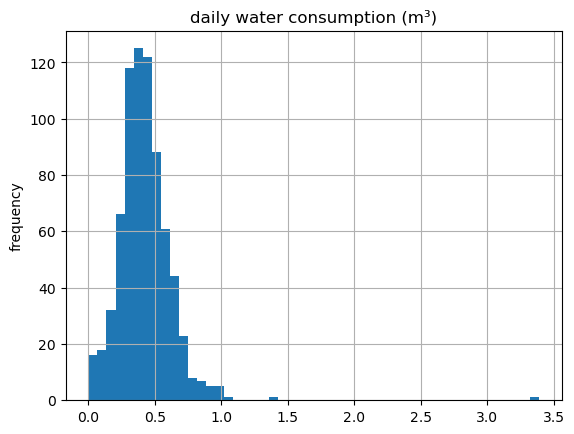

In [8]:
df['M3'].hist(bins=50)
plt.title('daily water consumption (m³)')
plt.ylabel('frequency')

How can we start to model this? A simple choice is to model each day’s consumption $c_i$ with a Gamma distribution. A Gamma distribution has a single shape parameter $a$, see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy.stats.gamma). To fit the Gamma distribution to our data using builtin `scipy` functions, we can do this:

In [9]:
from scipy.stats import gamma

data = df['M3'].values
shape, loc, scale = gamma.fit(data, loc=0)

shape, loc, scale

(10.893046994811282, -0.20049479019006658, 0.057162527280664094)

Let’s check if this is a good model by plotting the probability of seeing a given daily value versus measured values.

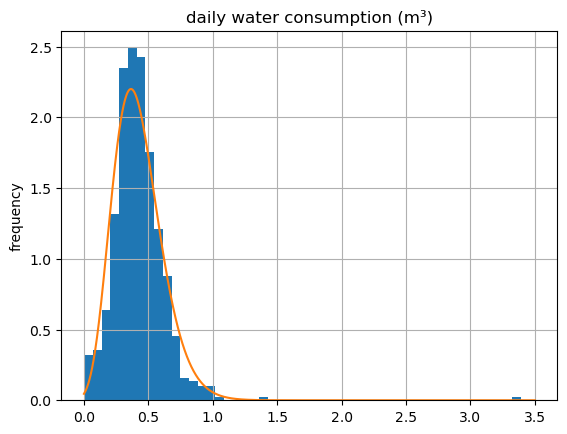

In [10]:
import numpy as np

df['M3'].hist(bins=50, density=True)
plt.title('daily water consumption (m³)')
plt.ylabel('frequency')
x = np.linspace(0, 3.5, num=1000)
plt.plot(x, gamma.pdf(x, shape, loc, scale))

This looks okay to me, even though this model does not take into account extreme values (such as the 3.5 m³ on Christmas 2022).

Since I want to use `pymc` for modelling the appearance of a water leak, I will redo the above "fit" using a different way, i.e. MCMC instead of a maximum likelihood estimation as `scipy.gamma.fit` has done above. This should, of course, lead to similar results.

In `pymc`, a Gamma distribution is [parametrized by two parameters, α and β](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Gamma.html), not just one like in Scipy. So we need to estimate these two parameters instead of one and see if we get similar results.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 42 seconds.


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

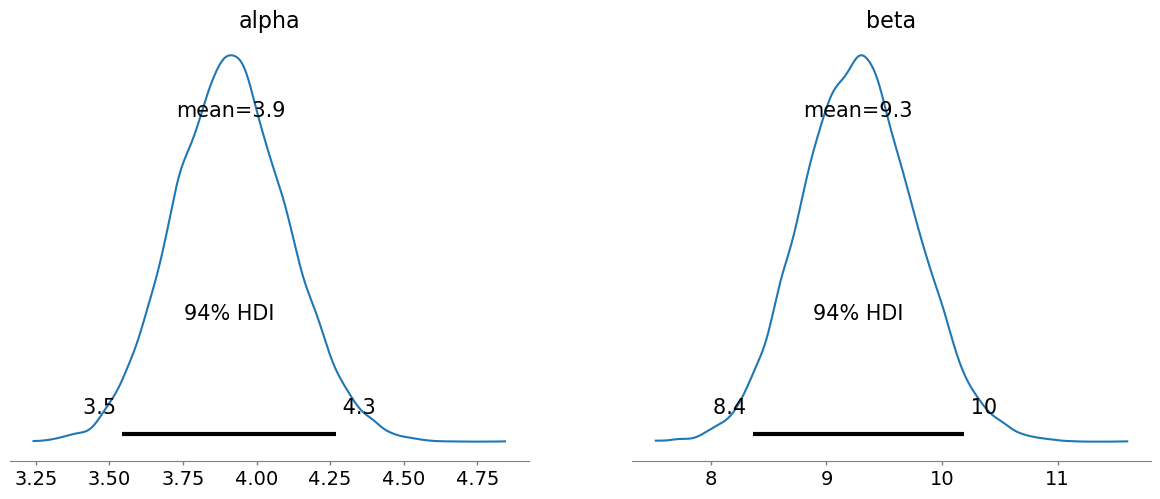

In [11]:
import pymc as pm

with pm.Model() as model:
    alpha = pm.Uniform("alpha", lower=0, upper=20)  # Flat prior for shape parameter
    beta = pm.Uniform("beta", lower=0, upper=20)  # Flat prior for shape parameter
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Gamma("obs", alpha=alpha, beta=beta, observed=data)
    
    # Sample from the posterior
    trace = pm.sample(5000, tune=1000, return_inferencedata=True)

# Plot the posterior distributions
pm.plot_posterior(trace, var_names=["alpha", "beta"])

Let’s check if the results make sense by overlaying the model with the data. 

A first way to do so is to sample the "fitted" distributions for simulated daily samples and compare their distribution with historical data.

Sampling: [obs]


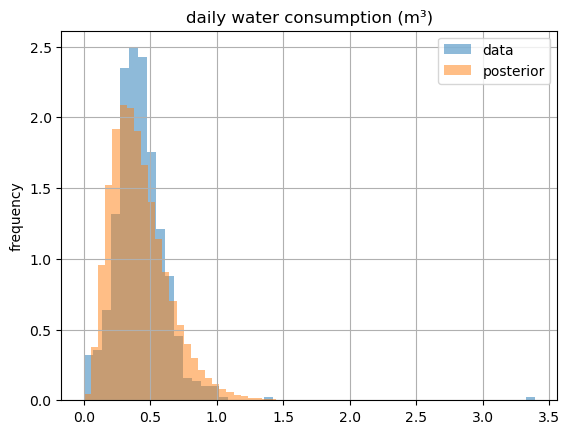

In [12]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["obs"], predictions=True)


posterior_samples = posterior_predictive.predictions['obs'].values.ravel()

df['M3'].hist(bins=50, density=True, label='data', alpha=0.5)
plt.title('daily water consumption (m³)')
plt.ylabel('frequency')
plt.hist(posterior_samples, bins=50, density=True, label='posterior', alpha=0.5)

plt.legend()

This seems like a good fit of the data. Another check we can do is to extract the mean values of α and β and plot the PDF of the Gamma distribution with these parameters.

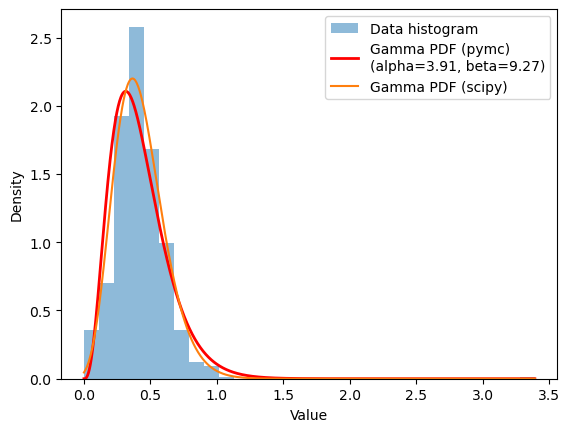

In [13]:
alpha_mean, beta_mean = trace.posterior.alpha.mean().values, trace.posterior.beta.mean().values

x = np.linspace(0, data.max(), 1000)
gamma_pdf = gamma.pdf(x, a=alpha_mean, scale=1/beta_mean)

plt.hist(data, bins=30, density=True, alpha=0.5, label="Data histogram")
plt.plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma PDF (pymc)\n(alpha={alpha_mean:.2f}, beta={beta_mean:.2f})')
plt.plot(x, gamma.pdf(x, shape, loc, scale), label='Gamma PDF (scipy)')
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

This seems, again, a good model (and similar to the one fitted with `scipy` before).

We now want to make a better model, that includes a **point in time at which a leak will appear**.

# Bayesian modelling of the water leak: dynamic time model

As we have already done in the previous section, we can write that every observation is a sample from a Gamma distribution parametrized by $(\alpha, \beta)$, the shape factors.

$$
c_i \sim \Gamma(\alpha, \beta)
$$

Of course, we don’t know what $(\alpha, \beta)$ is, we would like to estimate it with the data, as we have done in the previous static model.

But now, we also suppose there is a time $\tau$ when the leak starts, and we expect the shape of the distribution to change at this point. This also implies that the shape factors $(\alpha, \beta)$ change at that point, i.e.

$$
\left \lbrace 
\begin{aligned} 
c_i \sim \Gamma(\alpha_1, \beta_1) & &\text{if } t<\tau \\
c_i \sim \Gamma(\alpha_2, \beta_2) & &\text{if } t\geq\tau \\
\end{aligned}
\right .
$$

Because the daily data is so noisy, we can just assume that $\tau$ could be anywhere in the data we have collected. 

$$
\tau \sim \text{DiscreteUniform(1, 741)}
$$

Let’s code this with `pymc` and infer the distributions from the data.

In [14]:
n_count_data = data.size

with pm.Model() as model:
    alpha_1 = pm.Uniform("alpha_1", lower=0, upper=20)  # Flat prior for shape parameter
    beta_1 = pm.Uniform("beta_1", lower=0, upper=20)  # Flat prior for shape parameter
    alpha_2 = pm.Uniform("alpha_2", lower=0, upper=20)  # Flat prior for shape parameter
    beta_2 = pm.Uniform("beta_2", lower=0, upper=20)  # Flat prior for shape parameter
    idx = np.arange(n_count_data) # Index
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    alpha_ = pm.math.switch(tau > idx, alpha_1, alpha_2)
    beta_ = pm.math.switch(tau > idx, beta_1, beta_2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Gamma("obs", alpha=alpha_, beta=beta_, observed=data)

    # Sample from the posterior
    trace = pm.sample(5000, tune=1000, return_inferencedata=True)

    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_1, beta_1, alpha_2, beta_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 65 seconds.


Let’s plot the posteriors we have found.

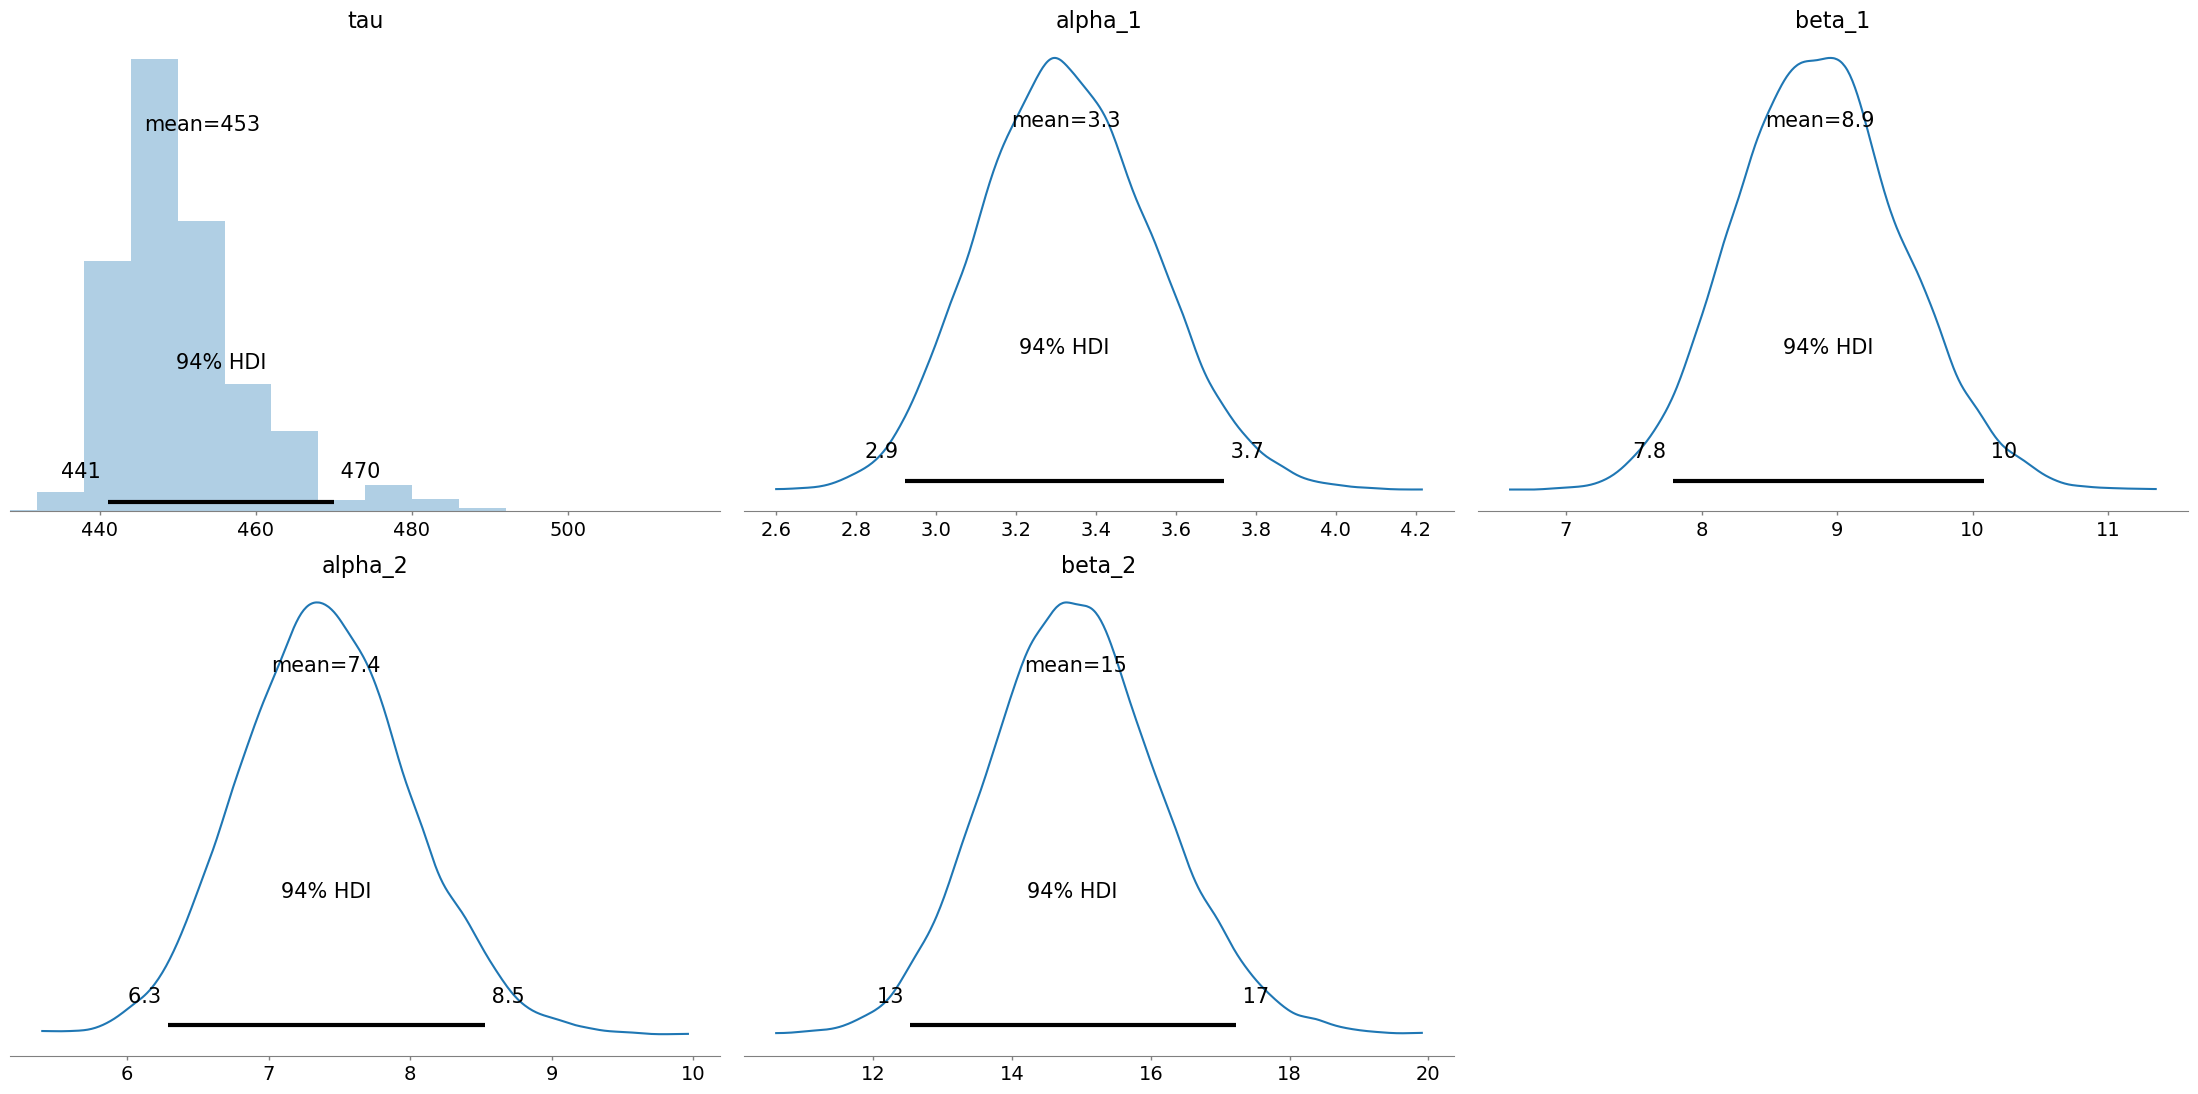

In [15]:
pm.plot_posterior(trace)
plt.tight_layout()

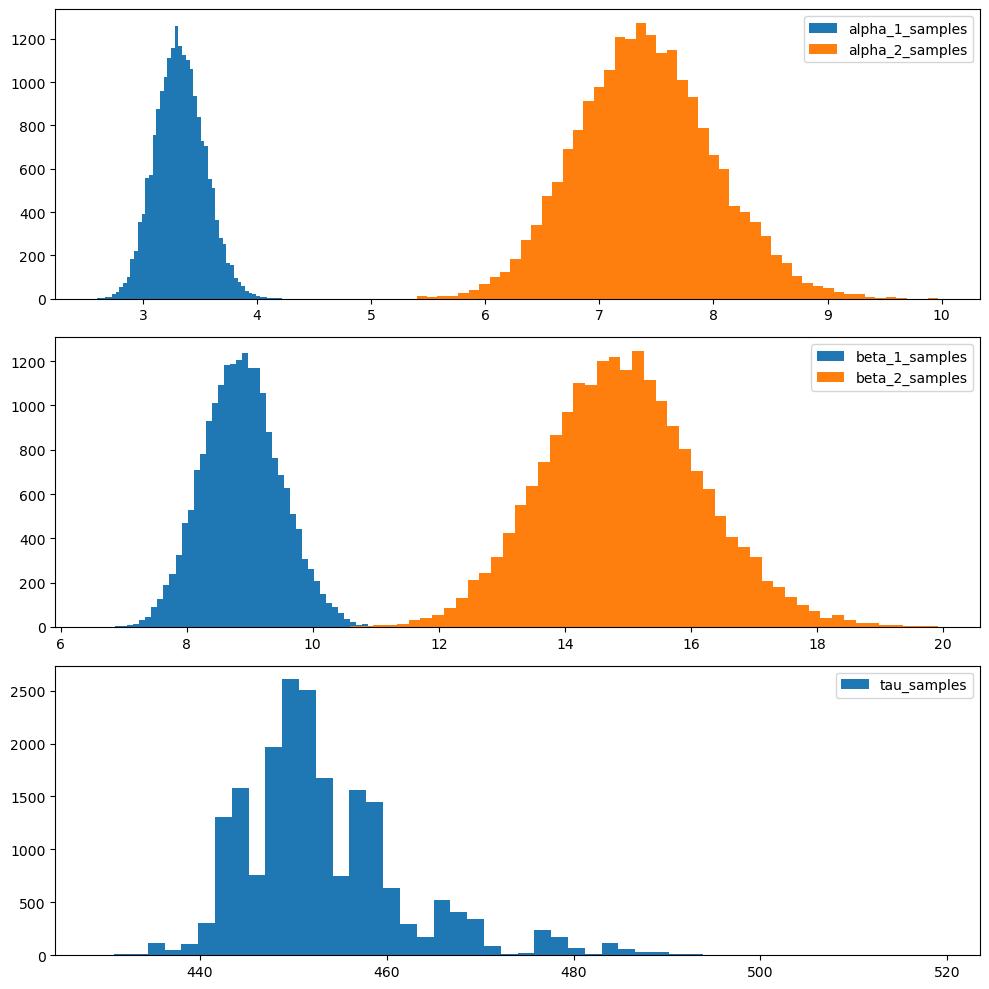

In [16]:
alpha_1_samples = trace.posterior.alpha_1.values.ravel()
alpha_2_samples = trace.posterior.alpha_2.values.ravel()
beta_1_samples = trace.posterior.beta_1.values.ravel()
beta_2_samples = trace.posterior.beta_2.values.ravel()
tau_samples = trace.posterior.tau.values.ravel()

fig, axes = plt.subplots(nrows=3, figsize=(10, 10))

for ax, vars, labels in zip(axes.ravel(), 
                   [[alpha_1_samples, alpha_2_samples], [beta_1_samples, beta_2_samples], [tau_samples]],
                   ['alpha_1_samples, alpha_2_samples'.split(', '), 'beta_1_samples, beta_2_samples'.split(', '), ['tau_samples']]):
    for var, label in zip(vars, labels):
        ax.hist(var, bins=50, label=label)
    ax.legend()
fig.tight_layout()

As we can see in the graph above, it seems the distributions are indeed quite different! Also, we see that the model has picked two points in time at which there could be a switch. 

Let’s try to visualize how different the before and after distributions are.

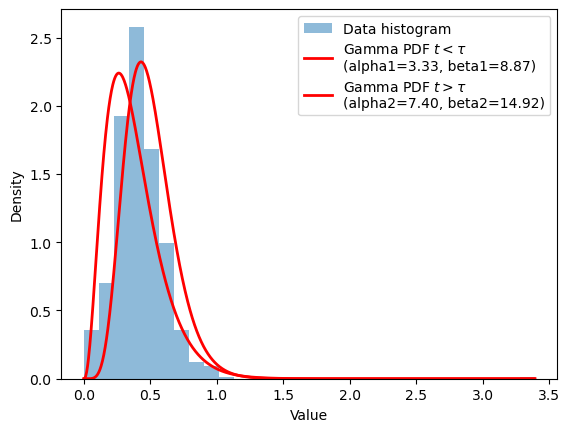

In [17]:
alpha_mean1, beta_mean1 = trace.posterior.alpha_1.mean().values, trace.posterior.beta_1.mean().values
alpha_mean2, beta_mean2 = trace.posterior.alpha_2.mean().values, trace.posterior.beta_2.mean().values

x = np.linspace(0, data.max(), 1000)
gamma_pdf1 = gamma.pdf(x, a=alpha_mean1, scale=1/beta_mean1)
gamma_pdf2 = gamma.pdf(x, a=alpha_mean2, scale=1/beta_mean2)

plt.hist(data, bins=30, density=True, alpha=0.5, label="Data histogram")
plt.plot(x, gamma_pdf1, 'r-', lw=2, label=f'Gamma PDF $t<\\tau$\n(alpha1={alpha_mean1:.2f}, beta1={beta_mean1:.2f})')
plt.plot(x, gamma_pdf2, 'r-', lw=2, label=f'Gamma PDF $t>\\tau$\n(alpha2={alpha_mean2:.2f}, beta2={beta_mean2:.2f})')
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Indeed, we see an increase in mean value to the right based on the inferred distributions.

We can also try to plot the location of the change with respect to the daily consumptions.

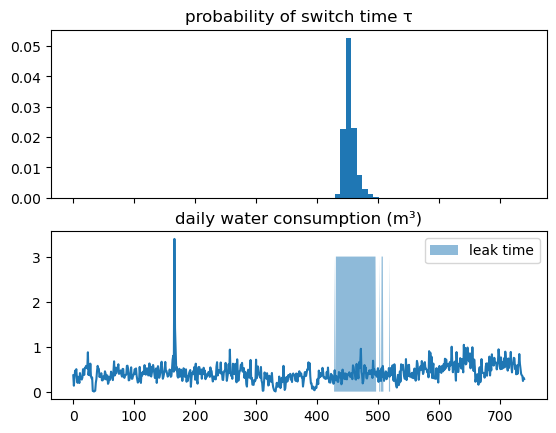

In [18]:
fig, (ax2, ax1) = plt.subplots(sharex=True, nrows=2)
ax1.plot(data)
ax1.set_title("daily water consumption (m³)")
ax2.hist(trace.posterior.tau.values.ravel(), density=True);
ax2.set_title("probability of switch time τ")
ax1.fill_between(np.arange(n_count_data)[:-1], 3 * (np.histogram(trace.posterior.tau.values.ravel(), bins=np.arange(n_count_data))[0] > 0.007), alpha=0.5, label='leak time')
ax1.legend()

Finally, let’s try to visualize the expected mean consumption as a factor of time by averaging the posterior sample results.

In [19]:
with model:
    predictions = pm.sample_posterior_predictive(trace, var_names=["obs"], predictions=True)

Sampling: [obs]


Let’s overlay a couple of these predictions.

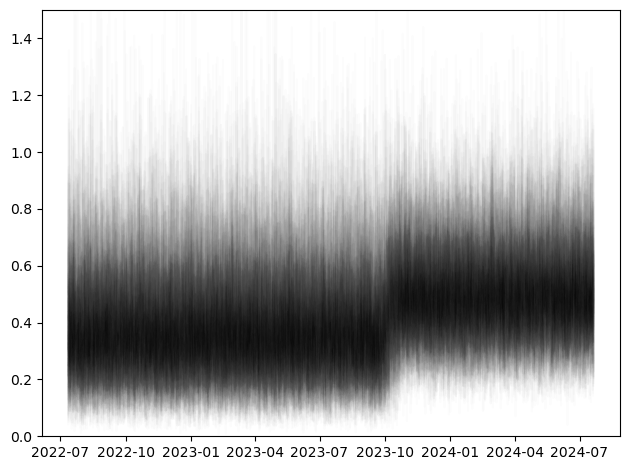

In [20]:
predictions_samples = predictions.predictions['obs'].values.reshape(-1, 741)

fig, ax = plt.subplots()
ax.plot(df.index, predictions_samples[np.random.choice(np.arange(predictions_samples.shape[0]), size=150)].T, alpha=0.01, color='k');
ax.set_ylim(0, 1.5)
fig.tight_layout()

The samples clearly show the change in behavior. We can also look at the mean values from the samples.

Text(0.5, 1.0, 'daily water consumption (m³)')

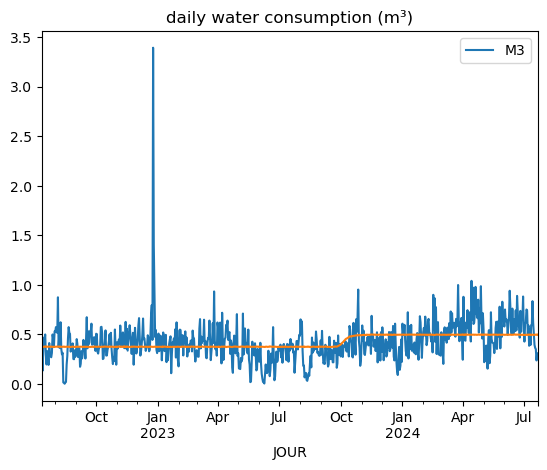

In [21]:
mean_predictions = predictions.predictions['obs'].mean(axis=0).mean(axis=0).values

fig, ax = plt.subplots()

df.plot(y='M3', ax=ax)
ax.plot(df.index, 
        mean_predictions)

ax.set_title("daily water consumption (m³)")

This plot indicates that the change in consumption, which could indicate a leak or change in beavior, dates back to at least October 2023. Interestingly, the model also seems to point to another, less probable change, around February 2024.


The most probable date for the change is:

In [22]:
s = pd.Series(tau_samples).value_counts()

df.index[s.index[0]]

Timestamp('2023-10-05 00:00:00')

Now, of course, you might say that there are better ways to find a leak than a Bayesian model. I agree, of course! However, I find that this is a very powerful way of finding a spot where to look in the data and think about what might have changed.

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20240730_bayesian_leak_model.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20240730_bayesian_leak_model.ipynb).*